In [88]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import data_tools
import xarray as xr
import pandas as pd
import datetime

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

%matplotlib inline

In [86]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [98]:
SC = data_tools.get_chs_tides('obs', 'Sandy Cove', '2017-11-30 00:05:00', '2018-01-08 23:54:00')

In [4]:
import os
HINDCAST_PATH = '/results/SalishSea/nowcast-green/'

In [99]:
SC.shape

(56752,)

In [100]:
list_of_model_ssh = np.array([])
for n in range(56752):
    date = pd.to_datetime(SC.index[n])
    if ((date.hour == 0) & (date.minute < 5)):
        before = (datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (23), minute = 55) - datetime.timedelta(days=1))
    elif date.minute < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = date.hour-1, minute = 55)
    elif date.minute%10 < 5:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) - 5)
    else:
        before = datetime.datetime(year = date.year, month = date.month, day = date.day, 
                           hour = (date.hour), minute = 10*(date.minute//10) + 5)  
    delta = (date - before).seconds / 600
    after = before + datetime.timedelta(minutes = 10)
    subdir = before.strftime('%d%b%y').lower()
    file = nc.Dataset(os.path.join(HINDCAST_PATH, subdir, 'SandyCove.nc'))
    subdir2 = after.strftime('%d%b%y').lower()
    file2 = nc.Dataset(os.path.join(HINDCAST_PATH, subdir2, 'SandyCove.nc'))
    s_val = ((1-delta) * file.variables['sossheig'][before.hour*6 + before.minute//10] + 
           delta*file2.variables['sossheig'][after.hour*6 + after.minute//10])
    list_of_model_ssh = np.append(list_of_model_ssh, s_val)

In [101]:
list_of_model_ssh[:10] + 3.09

array([ 3.7071326 ,  3.69865486,  3.69017711,  3.68169942,  3.67322167,
        3.66474393,  3.65626618,  3.64778843,  3.63931074,  3.630833  ])

In [102]:
SC[5:15]

2017-11-30 00:10:00    3.75
2017-11-30 00:11:00    3.74
2017-11-30 00:12:00    3.74
2017-11-30 00:13:00    3.73
2017-11-30 00:14:00    3.72
2017-11-30 00:15:00    3.71
2017-11-30 00:16:00    3.70
2017-11-30 00:17:00    3.69
2017-11-30 00:18:00    3.68
2017-11-30 00:19:00    3.67
Name: 07786 Sandy Cove water levels, dtype: float64

In [103]:
from matplotlib.colors import LogNorm

bias =  0.0245715353539
RMSE = 0.12299214737
Willmott = 0.996799625437


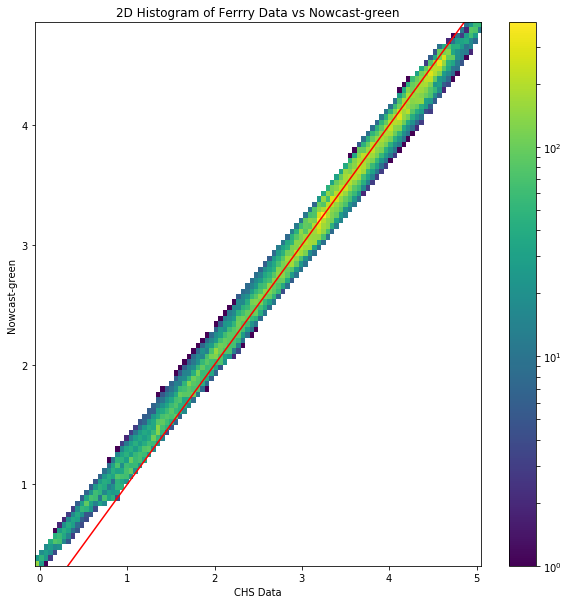

In [104]:
fig, ax = plt.subplots(figsize = (10,10))
c, xedge, yedge, im = ax.hist2d(SC.values, 
                                list_of_model_ssh + 3.09, bins = 100, norm=LogNorm())
im
fig.colorbar(im, ax=ax)
ax.set_xlabel('CHS Data')
ax.set_ylabel('Nowcast-green')
ax.set_title('2D Histogram of Ferrry Data vs Nowcast-green')
ax.plot(np.arange(-1,6),np.arange(-1, 6), 'r')
obs = SC.values
print('bias =  ' + str(-np.mean(obs) + np.mean(list_of_model_ssh + 3.09)))
print('RMSE = ' + str(np.sqrt(np.sum(((list_of_model_ssh+3.09) - obs)**2) / len(list_of_model_ssh))))
xbar = np.mean(obs)
print('Willmott = ' + str(1-(np.sum(((list_of_model_ssh+3.09) - obs)**2)  / 
                             np.sum((np.abs((list_of_model_ssh+3.09) - xbar) 
                                     + np.abs(obs - xbar))**2))))

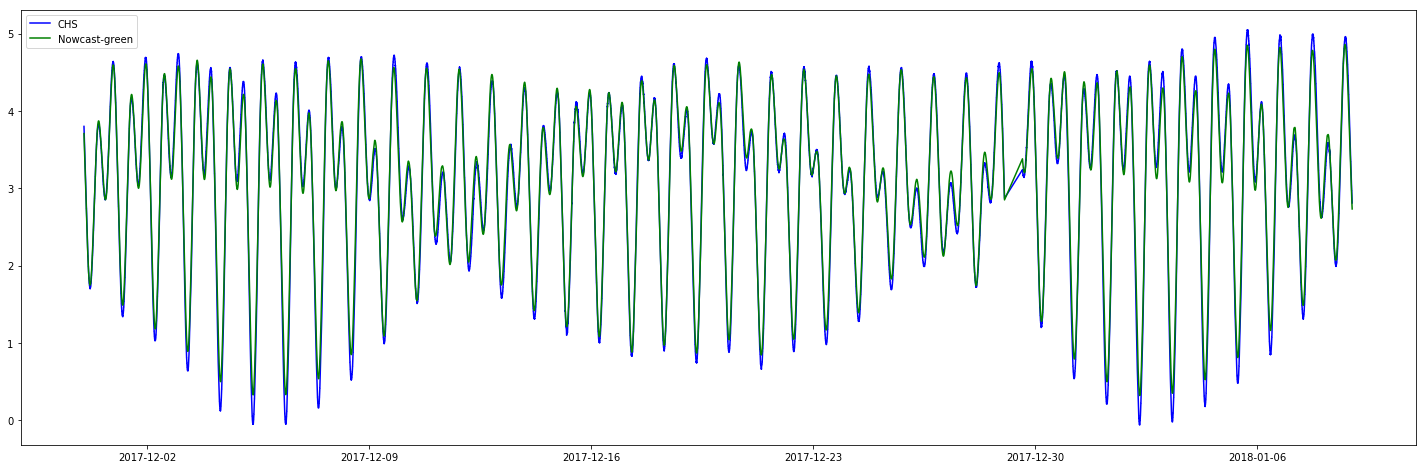

In [106]:
fig, ax = plt.subplots(figsize = (25,8))
ax.plot(SC.index.values, SC.values, 'b', label = 'CHS')
ax.plot(SC.index.values, list_of_model_ssh + 3.09, 'g', label = 'Nowcast-green')
ax.legend()